In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as td
import numpy as np
import os
import random
from PIL import Image
from scripts.unet_model import *

In [21]:
image_dir = '/application/pi/Desktop/all imp data/Unet_training/images/'
mask_dir = '/application/pi/Desktop/all imp data/Unet_training/masks/'

In [22]:
class PlaneDataSet(td.Dataset):
    
    def __init__(self, image_path, mask_path):
        import os
        
        self.image_path = image_path
        self.mask_path = mask_path
        c = os.listdir(mask_path)
        c.remove('.ipynb_checkpoints')
        self.filenames = c
        
        self.filenames 
    def __getitem__(self, index):
        
        # Get a random intenger between 1 and 2
        rand = random.randint(0, 2)     
        
        #Load the image
        img_path = os.path.join(self.image_path, self.filenames[index])
        image =  np.load(img_path)
        
        # Normalize the image pixels between 0 and 1
        image_np = image
        
        # Randomly flip the image half the time
#         if rand > 1:
#             image_pil = Image.fromarray(image_np).transpose(Image.FLIP_LEFT_RIGHT).convert("L")          
#             image_np = np.array(image_pil)
        
        # Add a dimension and convert to a tensor
        #image_np = np.expand_dims(image_np, axis=0)
        image_tensor = torch.Tensor(image_np)
        
        # Now do all the same stuff to the mask image
        mask_path = os.path.join(self.mask_path, self.filenames[index])
        mask =  np.load(mask_path)
        #mask_np = mask
        mask_np = np.expand_dims(mask, axis=0)
        mask_tensor = torch.Tensor(mask_np)
        
        return(image_tensor, mask_tensor)
    
    def __len__(self):
        return len(self.filenames)

In [23]:
def load_data(image_path, mask_path):

    # Load all of the images, transforming them
    dataset = PlaneDataSet(image_path , mask_path)
    
    # define a loader for the image data
    image_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=2,
        num_workers=0,
        shuffle=True
    )
    
        
    return image_loader

image_loader = load_data(image_dir, mask_dir)

In [24]:
(image_loader.dataset[0])

(tensor([[[ 236.,  236.,  236.,  ...,  304.,  299.,  299.],
          [ 236.,  236.,  236.,  ...,  304.,  299.,  299.],
          [ 236.,  236.,  236.,  ...,  304.,  299.,  299.],
          ...,
          [ 218.,  218.,  218.,  ...,  414.,  395.,  395.],
          [ 218.,  218.,  218.,  ...,  414.,  395.,  395.],
          [ 218.,  218.,  218.,  ...,  414.,  395.,  395.]],
 
         [[ 310.,  301.,  277.,  ...,  175.,  228.,  237.],
          [ 299.,  282.,  288.,  ...,  197.,  264.,  252.],
          [ 331.,  320.,  337.,  ...,  202.,  245.,  260.],
          ...,
          [ 160.,  162.,  176.,  ...,  580.,  563.,  553.],
          [ 154.,  171.,  207.,  ...,  622.,  617.,  591.],
          [ 200.,  263.,  294.,  ...,  640.,  660.,  669.]],
 
         [[ 522.,  493.,  504.,  ...,  303.,  408.,  365.],
          [ 565.,  542.,  528.,  ...,  325.,  433.,  433.],
          [ 575.,  601.,  592.,  ...,  345.,  440.,  470.],
          ...,
          [ 248.,  302.,  354.,  ...,  850.,  852

In [11]:
!wget "https://aka.ms/unet-pt" -O ~/unet.pt

--2020-05-19 17:04:31--  https://aka.ms/unet-pt
Resolving aka.ms (aka.ms)... 104.102.53.13
Connecting to aka.ms (aka.ms)|104.102.53.13|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://onedrive.live.com/download?cid=783D202C58C75CC2&resid=783D202C58C75CC2%21106&authkey=AC-jDrEgK0Phd6E [following]
--2020-05-19 17:04:31--  https://onedrive.live.com/download?cid=783D202C58C75CC2&resid=783D202C58C75CC2%21106&authkey=AC-jDrEgK0Phd6E
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://asm0nq.bn.files.1drv.com/y4mCNiGIl_J1vKQeYxOKkcyGFnAKwaCoC3V6YIOV8wMoVpd9noT6bRzvnD39AtwBJ2Owr-3auTZcUMgIIZhgwza6OIdKfpR91AO88Tv1iyEdD-ael06P9No574XiCVTm4KwrgqHIbQp2i3-vJRPvdG8-AGlyCQZo6U9ANVY-bl6fT_D8y5h5j9ioOSZlGi1jk1JjOrdOC2WcFGnFLQ-ZuK2Eg/unet.pt?download&psid=1 [following]
--2020-05-19 17:04:32-- 

In [25]:
def train(model, device, data_loader, optimizer, epoch):
    
    model.to(device)
    model.train()
    
    train_loss = 0
    print("Epoch:", epoch, "...")
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(data_loader):
        
        
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_training_loss = train_loss / (batch_idx+1)
    print("\tTraining set: Average loss: {:.6f}".format(avg_training_loss))
    return avg_training_loss


In [26]:
# Create a UNet model
model = UNet(n_channels=12, n_classes = 1)

# Use the best available device (GPU/CPU) for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Load the weights
# home = os.path.expanduser("~")
# weights_file = os.path.join(home, "unet.pt")
# model.load_state_dict(torch.load(weights_file, map_location=device))

# Specify the optimizer and  loss criteria
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_criteria = nn.BCELoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []

epochs = 1
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, image_loader, optimizer, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)

Training on cpu
Epoch: 1 ...
	Training set: Average loss: 0.303873


In [27]:
torch.save(model.state_dict(), '/application/pi/unet_trained.pt')

In [29]:
!conda install matplotlib


Solving environment: \ ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [35]:
model(image_loader.dataset[60][0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 12, 3, 3], but got 3-dimensional input of size [12, 512, 512] instead

In [38]:
for batch_idx, (data, target) in enumerate(image_loader):
    if batch_idx == 10:
        break
    data1 = data
    target1 = target

In [53]:
with torch.no_grad():
        output = model(data1)

In [56]:
a=np.array(output[0])
b=np.array(target1[0])

In [59]:
np.save('trial_image.npy',a)
np.save('trial_mask.npy',b)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
a =np.load('trial_image.npy')
b =np.load('trial_mask.npy')

In [11]:
b[0].shape

(512, 512)

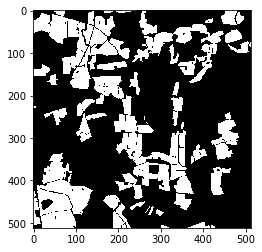

In [12]:
plt.imshow(b[0],cmap ='gray')

In [14]:
a[0].shape

(512, 512)

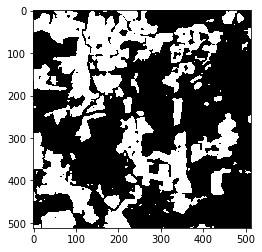

In [21]:
plt.imshow((a[0]>0.25)*1,cmap ='gray')